In [17]:
import pickle
import bz2
import gzip
import lzma
import pickle
import numpy as np
import pandas as pd

from scipy.signal import butter, lfilter

In [7]:
with open('emorec_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [19]:
data.head()

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
2883,148.15216,0.49825,0.46377,147.79085,0.36131,257.0,1.0,0.00574,1.0,0.00581,1.0,STIMULI_ONSET1,emorecm4623_e
2884,148.17009,0.49826,0.46133,147.79085,0.37924,257.0,1.0,0.00568,1.0,0.00584,1.0,STIMULI_ONSET1,emorecm4623_e
2885,148.18607,0.49806,0.45905,147.79085,0.39522,257.0,1.0,0.00571,1.0,0.00584,1.0,STIMULI_ONSET1,emorecm4623_e
2886,148.20239,0.49787,0.45710,147.79085,0.41154,257.0,1.0,0.00571,1.0,0.00583,1.0,STIMULI_ONSET1,emorecm4623_e
2887,148.22081,0.49771,0.45584,147.79085,0.42996,257.0,1.0,0.00568,1.0,0.00581,1.0,STIMULI_ONSET1,emorecm4623_e


In [4]:
# open participants_compressed.pbz2
with bz2.open('participants_compressed.pbz2', 'rb') as f:
    participants = pickle.load(f)

In [5]:
participants.head()
data = participants
data.head()

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
2883,148.15216,0.49825,0.46377,147.79085,0.36131,257.0,1.0,0.00574,1.0,0.00581,1.0,STIMULI_ONSET1,emorecm4623_e
2884,148.17009,0.49826,0.46133,147.79085,0.37924,257.0,1.0,0.00568,1.0,0.00584,1.0,STIMULI_ONSET1,emorecm4623_e
2885,148.18607,0.49806,0.45905,147.79085,0.39522,257.0,1.0,0.00571,1.0,0.00584,1.0,STIMULI_ONSET1,emorecm4623_e
2886,148.20239,0.49787,0.45710,147.79085,0.41154,257.0,1.0,0.00571,1.0,0.00583,1.0,STIMULI_ONSET1,emorecm4623_e
2887,148.22081,0.49771,0.45584,147.79085,0.42996,257.0,1.0,0.00568,1.0,0.00581,1.0,STIMULI_ONSET1,emorecm4623_e


In [8]:
# Validating if ratio of valid data is above 70% - possible exclusion of users.
data_1 = pd.pivot_table(data, values=["FPOGV"], index="USER", aggfunc=[np.sum, "count"])
data_1["ratio"] = data_1["sum"] / data_1["count"]
data_1

,sum,count,ratio
,FPOGV,FPOGV,
USER,,,
STIMULI_ONSET1,96033.0,114733,0.837013
STIMULI_ONSET10,76189.0,96267,0.791434
STIMULI_ONSET11,80400.0,100119,0.803044
STIMULI_ONSET12,83243.0,105035,0.792526
STIMULI_ONSET13,86268.0,109584,0.787232
STIMULI_ONSET14,86229.0,105437,0.817825
STIMULI_ONSET15,82248.0,102384,0.803329
STIMULI_ONSET16,93750.0,116334,0.805869


In [14]:
# Filtering with respect to non-null values of FPOGV, LPUPILV and RPUPILV

data_filtered = data.loc[(data["FPOGV"] == 1) & (data["LPUPILV"] == 1) & (data["RPUPILV"] == 1),:]

In [26]:
df_lowpass = data_filtered.copy()

In [4]:
import pandas as pd
import math

# Specify fixation radius and minimum duration
fixation_radius = 58
min_duration = 0.12

# Get unique trial names
trials = data['USER'].unique()

# Loop through trials and calculate fixation count and duration
for trial in trials:
    trial_data = data[data['USER'] == trial]
    fixation_count = 0
    fixation_duration = 0
    last_fixation_end_time = float('nan')
    last_x = last_y = 0

    for index, row in trial_data.iterrows():
        x = row['FPOGX'] * 1920  # Convert fraction of screen to pixels
        y = row['FPOGY'] * 1080  # Convert fraction of screen to pixels

        if math.isnan(last_fixation_end_time):
            # First sample in trial
            fixation_start_time = row['FPOGS']
            last_fixation_end_time = fixation_start_time
        elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                row['FPOGS'] - last_fixation_end_time <= min_duration:
            # Continuing fixation
            pass
        elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                row['FPOGS'] - last_fixation_end_time > min_duration:
            # Extended fixation
            fixation_duration += row['FPOGS'] - last_fixation_end_time
            last_fixation_end_time = row['FPOGS'] + row['FPOGD']
        elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) > fixation_radius:
            # New fixation
            fixation_count += 1
            fixation_duration += row['FPOGD']
            fixation_start_time = row['FPOGS']
            last_fixation_end_time = row['FPOGS'] + row['FPOGD']

        last_x = x
        last_y = y

    # Print results for trial
    print(f"Trial: {trial}, Fixation Count: {fixation_count}, Fixation Duration: {fixation_duration:.2f} seconds")

Trial: STIMULI_ONSET1, Fixation Count: 2899, Fixation Duration: 2752.29 seconds
Trial: STIMULI_ONSET2, Fixation Count: 4060, Fixation Duration: 2657.17 seconds
Trial: STIMULI_ONSET3, Fixation Count: 3476, Fixation Duration: 2629.00 seconds
Trial: STIMULI_ONSET4, Fixation Count: 3731, Fixation Duration: 2619.60 seconds
Trial: STIMULI_ONSET5, Fixation Count: 3298, Fixation Duration: 2557.16 seconds
Trial: STIMULI_ONSET6, Fixation Count: 3606, Fixation Duration: 2698.81 seconds
Trial: STIMULI_ONSET7, Fixation Count: 4721, Fixation Duration: 3080.72 seconds
Trial: STIMULI_ONSET8, Fixation Count: 4601, Fixation Duration: 3325.07 seconds
Trial: STIMULI_ONSET9, Fixation Count: 3283, Fixation Duration: 2515.05 seconds
Trial: STIMULI_ONSET10, Fixation Count: 2884, Fixation Duration: 2328.80 seconds
Trial: STIMULI_ONSET11, Fixation Count: 3358, Fixation Duration: 7541.44 seconds
Trial: STIMULI_ONSET12, Fixation Count: 3781, Fixation Duration: 2709.36 seconds
Trial: STIMULI_ONSET13, Fixation Coun

In [22]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 3                                               #
#                                                            #
##############################################################

from sklearn.decomposition import PCA

from scipy.signal import butter, lfilter, filtfilt

def low_pass_filter(data_table, col, sampling_frequency, cutoff_frequency, order=5, phase_shift=True):
    # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
    nyq = 0.5 * sampling_frequency
    cut = cutoff_frequency / nyq

    b, a = butter(order, cut, btype='low', output='ba', analog=False)
    if phase_shift:
        data_table[col + '_lowpass'] = filtfilt(b, a, data_table[col])
    else:
        data_table[col + '_lowpass'] = lfilter(b, a, data_table[col])
    return data_table

In [42]:
df_lowpass["max_pupild"] = df_lowpass[["LPUPILD", "RPUPILD"]].max(axis=1)
fs = 1000/200
cutoff = 1
df_low_pass_final = low_pass_filter(df_lowpass.groupby("USER").mean(),"max_pupild", fs, cutoff)[["max_pupild", "max_pupild_lowpass"]]

<AxesSubplot:xlabel='USER'>

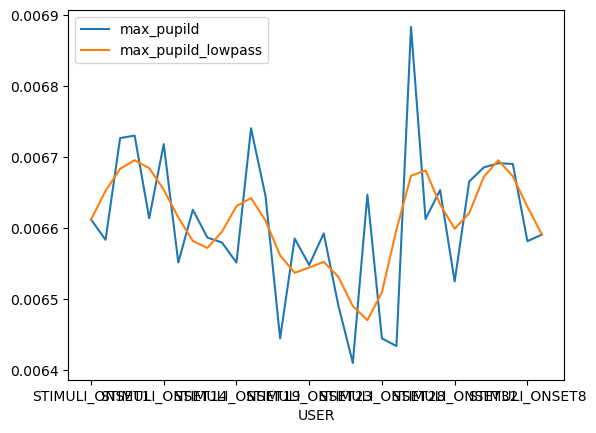

In [53]:
df_low_pass_final["z_score"] = (df_low_pass_final["max_pupild"] - np.mean(df_low_pass_final["max_pupild"])) / np.std(df_low_pass_final["max_pupild"])
df_low_pass_final[["max_pupild", "max_pupild_lowpass"]].plot()

<AxesSubplot:xlabel='USER'>

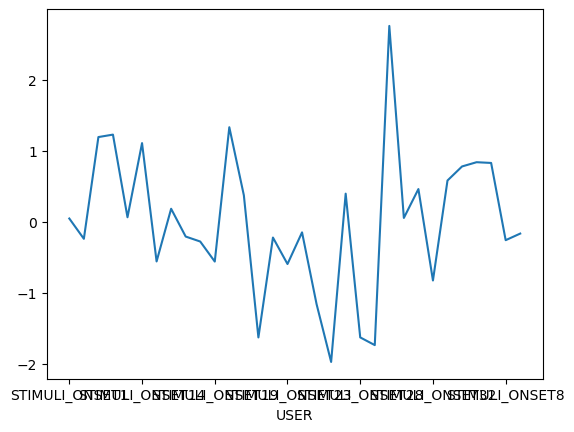

In [52]:
df_low_pass_final["z_score"].plot()
